In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import skimage.io
import tensorflow 
import tqdm
import glob

from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/dataset/TRAIN.zip > /dev/null

In [ ]:
!unzip gdrive/My\ Drive/dataset/TEST.zip > /dev/null

In [ ]:
train_o = glob.glob('/content/TRAIN/O/*.jpg')
a = len(train_o)




In [ ]:
train_r = glob.glob('/content/TRAIN/R/*.jpg')
b = len(train_r)

In [ ]:
print("Nos of training samples: {}".format(a+b))

Nos of training samples: 22564


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128, 
                                                   subset = 'training')

Found 18052 images belonging to 2 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128, 
                                                  subset = 'validation')

Found 4512 images belonging to 2 classes.


In [ ]:
# Class Indices 

train_dataset.class_indices

{'O': 0, 'R': 1}

100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


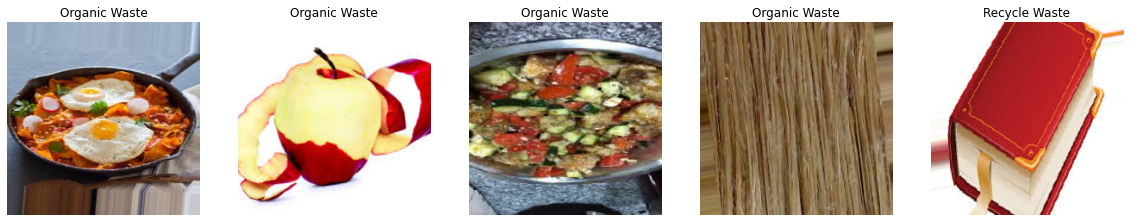

In [ ]:
# Viewing Images

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(128)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('Recycle Waste')
    else:
        ax[i].set_title('Organic Waste')

In [ ]:
# Defining Model

base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# Freezing Layers 

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Defining Layers

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [ ]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
# Model Fitting 

model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
142/142 [==============================] - ETA: 0s - loss: 0.3509 - auc: 0.9285
Epoch 1: val_auc improved from -inf to 0.95102, saving model to ./best_weights.hdf5
142/142 [==============================] - 267s 2s/step - loss: 0.3509 - auc: 0.9285 - val_loss: 0.2864 - val_auc: 0.9510
Epoch 2/10
142/142 [==============================] - ETA: 0s - loss: 0.2648 - auc: 0.9567
Epoch 2: val_auc improved from 0.95102 to 0.95572, saving model to ./best_weights.hdf5
142/142 [==============================] - 244s 2s/step - loss: 0.2648 - auc: 0.9567 - val_loss: 0.2681 - val_auc: 0.9557
Epoch 3/10
142/142 [==============================] - ETA: 0s - loss: 0.2406 - auc: 0.9640
Epoch 3: val_auc improved from 0.95572 to 0.95637, saving model to ./best_weights.hdf5
142/142 [==============================] - 239s 2s/step - loss: 0.2406 - auc: 0.9640 - val_loss: 0.2730 - val_auc: 0.9564
Epoch 4/10
142/142 [==============================] - ETA: 0s - loss: 0.2269 - auc: 0.9680
Epoch 4: val

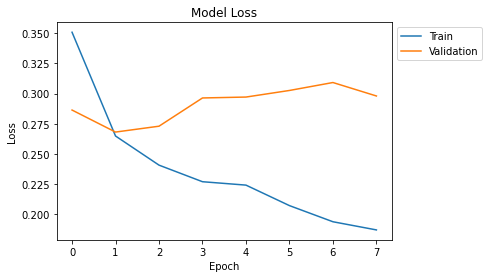

In [ ]:
# Summarize the model loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

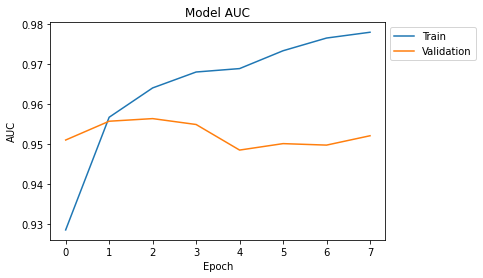

In [ ]:
# Summarize models auc

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# Test Data 

test_data = test_datagen.flow_from_directory(directory = '/content/TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 2513 images belonging to 2 classes.


In [ ]:
# Evaluating Loss and AUC - Test Data 

model.evaluate(test_data)

20/20 [==============================] - 18s 883ms/step - loss: 0.3512 - auc: 0.9449


[0.3512285649776459, 0.944948136806488]

The image belongs to Biodegradable waste 


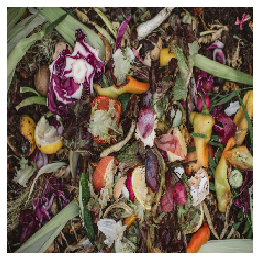

In [ ]:
# Test Case:1 - ORGANIC

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/Biodegradable waste.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Non Biodegradable waste")
else:
    print("The image belongs to Biodegradable waste ")

The image belongs to Non Biodegradable waste


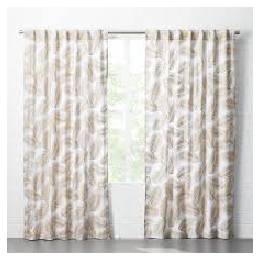

In [ ]:
# Test Case:2 - RECYCLE

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/TEST/R/R_10011.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Non Biodegradable waste")
else:
    print("The image belongs to Biodegradable waste")

updating: best_weights.hdf5 (deflated 8%)


<module 'google.colab.files' from '/usr/local/lib/python3.7/dist-packages/google/colab/files.py'>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model = load_model('best_weights.hdf5')



img = load_img(filepath, target_size=(224,224))
img = img_to_array(img)
img = img / 255
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Non Biodegradable waste")
else:
    print("The image belongs to Biodegradable waste")
